# M1 Coursework - Question 3

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from joblib import dump

from tensorflow.keras.datasets import mnist

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import optuna

np.random.seed(30)

## Importing MNIST Data 
- Due to complexity - optuna studies are preformed using 10,000 data points
- The best model is then trained using 50,000 model

In [2]:
# Import initial data set from mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalise the data
x_train = x_train / 255
x_test = x_test / 255

# Set the data type to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Randomly shuffle data to ensure even distribution of labels
# Shuffle 60,000 data set
indices_train = np.arange(len(x_train))
np.random.shuffle(indices_train)
x_train = x_train[indices_train]
y_train = y_train[indices_train]

# Shuffle 10,000 data set
indices_test = np.arange(len(x_test))
np.random.shuffle(indices_test)
x_test = x_test[indices_test]
y_test = y_test[indices_test]


# Create v stack input data 
train_double_size = 50000
test_double_size = 10000

# Generate random indices for the double data set
# Vectorised sampling with replacement
train_double_indices =  [np.random.randint(0, x_train.shape[0], train_double_size), np.random.randint(0, x_train.shape[0], train_double_size)]
test_double_indices =  [np.random.randint(0, x_test.shape[0], test_double_size), np.random.randint(0, x_test.shape[0], test_double_size)]

# Generate their corresponding images and labels at these indices
x_train_double = np.concatenate((x_train[train_double_indices[0]], x_train[train_double_indices[1]]), axis=1) 
y_train_double = np.add(y_train[train_double_indices[0]], y_train[train_double_indices[1]])

x_test_double = np.concatenate((x_test[test_double_indices[0]], x_test[test_double_indices[1]]), axis=1)
y_test_double = np.add(y_test[test_double_indices[0]], y_test[test_double_indices[1]])

# Flatten the input data
x_train_double = x_train_double.reshape(x_train_double.shape[0], -1)
x_test_double = x_test_double.reshape(x_test_double.shape[0], -1)

# Create a smaller data set for optuna optimisation
# Create v stack input data 
train_double_size_optuna = 10000

# Generate random indices for the double data set
# Vectorised sampling with replacement
train_double_indices_optuna =  [np.random.randint(0, x_train.shape[0], train_double_size_optuna), np.random.randint(0, x_train.shape[0], train_double_size_optuna)]

# Generate their corresponding images and labels at these indices
x_train_double_optuna = np.concatenate((x_train[train_double_indices_optuna[0]], x_train[train_double_indices_optuna[1]]), axis=1) 
y_train_double_optuna = np.add(y_train[train_double_indices_optuna [0]], y_train[train_double_indices_optuna[1]])

# Flatten the input data
x_train_double_optuna = x_train_double_optuna.reshape(x_train_double_optuna.shape[0], -1)

# Print the shape of the data in table
data_shapes_double_inputs = pd.DataFrame({
    "Dataset": ["Optuna", "Training", "Test"],
    "Features Shape (x)": [x_train_double_optuna.shape, x_train_double.shape, x_test_double.shape],
    "Labels Shape (y)": [y_train_double_optuna.shape, y_train_double.shape, y_test_double.shape]
})
print(tabulate(data_shapes_double_inputs, headers='keys', tablefmt='grid'))

+----+-----------+----------------------+--------------------+
|    | Dataset   | Features Shape (x)   | Labels Shape (y)   |
+====+===========+======================+====================+
|  0 | Optuna    | (10000, 1568)        | (10000,)           |
+----+-----------+----------------------+--------------------+
|  1 | Training  | (50000, 1568)        | (50000,)           |
+----+-----------+----------------------+--------------------+
|  2 | Test      | (10000, 1568)        | (10000,)           |
+----+-----------+----------------------+--------------------+


## SVM Model
### Optuna Study
#### Hyperparameters scanned over
- **C**, Reguluarisation Parameter :  
  - A smaller  C  encourages a simpler model 
  - Larger C  aims to classify all training examples correctly, at risk of overfitting.
  - Range: 0.1 to 10 (logarithmic scale).
- **Gamma**, Kernel Coefficient:  
  - Range: 0.001 to 0.1 (logarithmic scale).

In [3]:
# Define the optuna objective function for the SVM model
def objective(trial):
    # Define the hyperparameter search space
    C = trial.suggest_float('C', 0.1, 10, log=True)
    gamma = trial.suggest_float('gamma', 0.001, 0.1, log=True)
    
    # Create the SVM model with the sampled hyperparameters
    model_svc = SVC(kernel='rbf', C=C, gamma=gamma)
    
    # Perform cross-validation and calculate the mean accuracy
    cv_scores = cross_val_score(model_svc, x_train_double_optuna, y_train_double_optuna, cv=3, scoring='accuracy', n_jobs=-1)
    
    # Return the mean cross-validation score as the objective value
    return cv_scores.mean()

# Define the an Optuna study
study_svm = optuna.create_study(direction='maximize', study_name="SVM_Hyperparameter_Optimisation")

# Optimize the study
study_svm.optimize(objective, n_trials=20) 

[I 2024-12-11 01:28:04,208] A new study created in memory with name: SVM_Hyperparameter_Optimisation
[I 2024-12-11 01:29:37,833] Trial 0 finished with value: 0.5200997304289517 and parameters: {'C': 7.6471624765335084, 'gamma': 0.0028578098053840275}. Best is trial 0 with value: 0.5200997304289517.
[I 2024-12-11 01:31:44,201] Trial 1 finished with value: 0.10350000206979305 and parameters: {'C': 0.21303323350839823, 'gamma': 0.07190003237379812}. Best is trial 0 with value: 0.5200997304289517.
[I 2024-12-11 01:33:17,771] Trial 2 finished with value: 0.206099674154578 and parameters: {'C': 0.38818677624156783, 'gamma': 0.003254251635286071}. Best is trial 0 with value: 0.5200997304289517.
[I 2024-12-11 01:34:50,482] Trial 3 finished with value: 0.16379964331166172 and parameters: {'C': 0.6670092171898472, 'gamma': 0.0013252371907110888}. Best is trial 0 with value: 0.5200997304289517.
[I 2024-12-11 01:36:26,903] Trial 4 finished with value: 0.2032999040755905 and parameters: {'C': 0.255

### SVM - Optuna Top 4 Results

In [4]:
# Create a table showing the top 4 best trails performed by optuna

# Extract the six best trials from the Optuna study
best_trials_svm = study_svm.trials_dataframe().nlargest(4, "value")

# Create a list of dictionaries to hold the trial results
best_results_svm = []
for index, row in best_trials_svm.iterrows():
    trial = study_svm.trials[int(row['number'])]
    result = {
        'Trial': trial.number,
        'Value': trial.value,
        **trial.params  # Unpack hyperparameters
    }
    best_results_svm.append(result)

# Convert to a DataFrame
best_results_svm_df = pd.DataFrame(best_results_svm)

# Convert to displayable table
table_best_trails_svm = tabulate(best_results_svm_df, headers='keys', tablefmt='grid')
print(table_best_trails_svm)

+----+---------+---------+---------+------------+
|    |   Trial |   Value |       C |      gamma |
+====+=========+=========+=========+============+
|  0 |      16 |  0.6075 | 4.39114 | 0.0128364  |
+----+---------+---------+---------+------------+
|  1 |      13 |  0.602  | 2.04349 | 0.0150522  |
+----+---------+---------+---------+------------+
|  2 |      11 |  0.5968 | 2.59261 | 0.0165499  |
+----+---------+---------+---------+------------+
|  3 |       9 |  0.5967 | 3.1142  | 0.00819242 |
+----+---------+---------+---------+------------+


### SVM best model trained on larger dataset and evaluated

In [5]:
# Extract the best hyperparameters
best_params_svm = study_svm.best_trial.params

# Train the best model on that larger data set (50,000 samples)
best_model_svm = SVC(kernel='rbf', C=best_params_svm['C'], gamma=best_params_svm['gamma'])

best_model_svm.fit(x_train_double, y_train_double)

# Predict and evaluate on the test set
y_test_double_pred_svm = best_model_svm.predict(x_test_double)

# Generate the classification report as a dictionary for converting to table
report_svm = classification_report(y_test_double, y_test_double_pred_svm, output_dict=True)

# Define overall accuracy
accuracy_svm = accuracy_score(y_test_double, y_test_double_pred_svm)

# Prepare data for tabulation
table_data_svm = []
for label, metrics in report_svm.items():
    if label.isdigit():  
        table_data_svm.append([
            int(label), 
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}",])

# Add overall accuracy at the end as a new row
table_data_svm.append(["Overall Accuracy", "-", "-", f"{accuracy_svm:.4f}"])

# Create tabulated report
headers_svm = ["Class", "Precision", "Recall", "F1-Score"]
table_svm_report = tabulate(table_data_svm, headers=headers_svm, tablefmt="grid")
print(table_svm_report)

# Save the best svm model in Results folder
dump(best_model_svm, 'Results/best_svm_model.joblib')

+------------------+-------------+----------+------------+
| Class            | Precision   | Recall   |   F1-Score |
+==================+=============+==========+============+
| 0                | 0.9355      | 0.9667   |     0.9508 |
+------------------+-------------+----------+------------+
| 1                | 0.9221      | 0.9783   |     0.9494 |
+------------------+-------------+----------+------------+
| 2                | 0.9417      | 0.9037   |     0.9223 |
+------------------+-------------+----------+------------+
| 3                | 0.8460      | 0.8794   |     0.8623 |
+------------------+-------------+----------+------------+
| 4                | 0.8530      | 0.8499   |     0.8514 |
+------------------+-------------+----------+------------+
| 5                | 0.8372      | 0.8079   |     0.8223 |
+------------------+-------------+----------+------------+
| 6                | 0.8343      | 0.8380   |     0.8361 |
+------------------+-------------+----------+-----------

['Results/best_svm_model.joblib']

### SVM Confusion Matrix

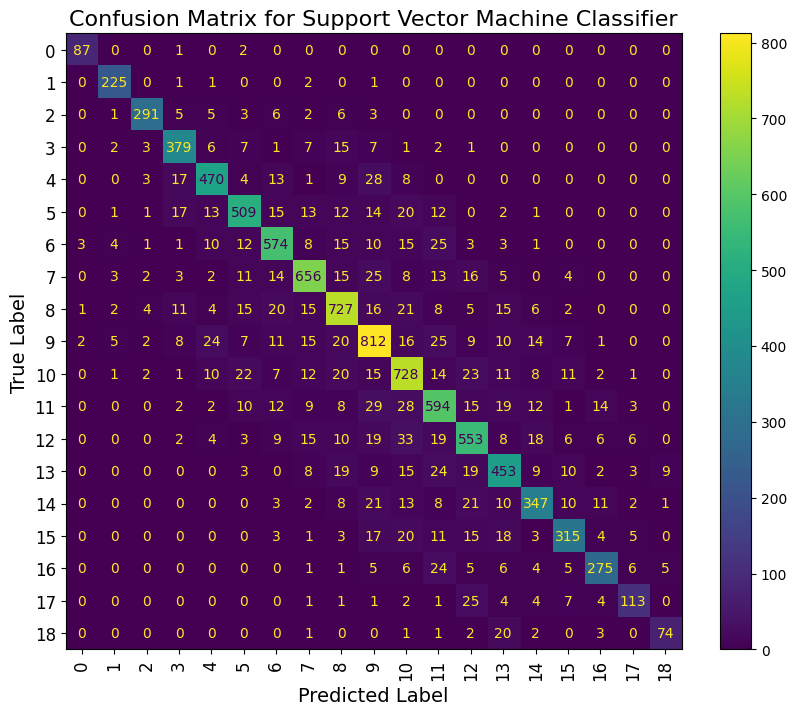

In [6]:
# Generate a confusion matrix
conf_matrix_svm = confusion_matrix(y_test_double, y_test_double_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=np.unique(y_test_double))

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap="viridis", xticks_rotation="vertical",
          ax=ax, colorbar=True)

plt.title("Confusion Matrix for Support Vector Machine Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Random Forest Model
### Optuna Study

#### Hyperparameters Scanned Over
- **n_estimators**:  
  - The number of trees in the forest.  
  - Range: 100 to 500 (in steps of 100).
  
- **max_depth**:  
  - The maximum depth of each decision tree.  
  - Values: 20, 30, 40, 50, and `None` (unrestricted depth).

- **min_samples_split**:  
  - The minimum number of samples required to split an internal node.  
  - Range: 2 to 8 (in steps of 3).

- **min_samples_leaf**:  
  - The minimum number of samples required to be at a leaf node.  
  - Range: 1 to 4 (in steps of 1).

In [7]:
# Define the optuna objective function for the random forest model
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)  # Number of trees
    max_depth = trial.suggest_categorical('max_depth', [20, 30, 40, 50, None])  # Maximum tree depth
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8, step=3)  # Minimum samples to split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4, step=1)  # Minimum samples per leaf

    # Create the Random Forest model
    model_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf, max_features='sqrt', random_state=42, n_jobs=-1)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model_rf, x_train_double_optuna, y_train_double_optuna, cv=3, scoring='accuracy', n_jobs=-1)
    
    # Return the mean cross-validation score
    return cv_scores.mean()

# Create an Optuna study
study_rf = optuna.create_study(direction='maximize', study_name="RF_Hyperparameter_Optimisation")

# Optimize the study
study_rf.optimize(objective, n_trials=30) 

[I 2024-12-11 02:46:09,308] A new study created in memory with name: RF_Hyperparameter_Optimisation
[I 2024-12-11 02:46:19,351] Trial 0 finished with value: 0.529400660521961 and parameters: {'n_estimators': 400, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.529400660521961.
[I 2024-12-11 02:46:30,077] Trial 1 finished with value: 0.5355009406159571 and parameters: {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.5355009406159571.
[I 2024-12-11 02:46:32,159] Trial 2 finished with value: 0.4810005895610557 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.5355009406159571.
[I 2024-12-11 02:46:38,575] Trial 3 finished with value: 0.5202004003639716 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.5355009406

### RF - Optuna Top 4 Results

In [8]:
# Create a table showing the top 4 best trails performed by optuna

# Extract the six best trials from the Optuna study
best_trials_rf = study_rf.trials_dataframe().nlargest(4, "value")

# Create a list of dictionaries to hold the trial results
best_results_rf = []
for index, row in best_trials_rf.iterrows():
    trial = study_rf.trials[int(row['number'])]
    result = {
        'Trial': trial.number,
        'Value': trial.value,
        **trial.params  # Unpack hyperparameters
    }
    best_results_rf.append(result)

# Convert to a DataFrame
best_results_rf_df = pd.DataFrame(best_results_rf)

# Convert to displayable table
table_best_trails_rf= tabulate(best_results_rf_df, headers='keys', tablefmt='grid')
print(table_best_trails_rf)

+----+---------+----------+----------------+-------------+---------------------+--------------------+
|    |   Trial |    Value |   n_estimators |   max_depth |   min_samples_split |   min_samples_leaf |
+====+=========+==========+================+=============+=====================+====================+
|  0 |      24 | 0.5537   |            500 |         nan |                   2 |                  1 |
+----+---------+----------+----------------+-------------+---------------------+--------------------+
|  1 |      26 | 0.5537   |            500 |         nan |                   2 |                  1 |
+----+---------+----------+----------------+-------------+---------------------+--------------------+
|  2 |      10 | 0.552401 |            500 |          20 |                   2 |                  1 |
+----+---------+----------+----------------+-------------+---------------------+--------------------+
|  3 |      11 | 0.552401 |            500 |          20 |                   2 |  

### Random Forest best model trained on larger dataset

In [9]:
# Extract the best hyperparameters
best_params = study_rf.best_trial.params

# Train the best model on the larger data set (50,000 samples)
best_model_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],
                                       min_samples_leaf=best_params['min_samples_leaf'], max_features='sqrt', random_state=42, n_jobs=-1)

best_model_rf.fit(x_train_double, y_train_double)

# Predict and evaluate on the test set
y_test_pred_rf = best_model_rf.predict(x_test_double)

# Generate the classification report as a dictionary for converting to table
report_rf = classification_report(y_test_double, y_test_pred_rf, output_dict=True)

# Define overall accuracy
accuracy_rf = accuracy_score(y_test_double, y_test_pred_rf)

# Prepare data for tabulation
table_data_rf = []
for label, metrics in report_rf.items():
    if label.isdigit():  # Include only class-specific metrics
        table_data_rf.append([
            int(label),  # Class label
            f"{metrics['precision']:.4f}",  # Precision for the class
            f"{metrics['recall']:.4f}",     # Recall for the class
            f"{metrics['f1-score']:.4f}",  # F1-score for the class
        ])

# Add overall accuracy at the end as a new row
table_data_rf.append(["Overall Accuracy", "-", "-", f"{accuracy_rf:.4f}"])

# Create tabulated report
headers_rf = ["Class", "Precision", "Recall", "F1-Score"]
table_rf_report = tabulate(table_data_rf, headers=headers_rf, tablefmt="grid")
print(table_rf_report)

# Save the best svm model
dump(best_model_rf, 'Results/best_rf_model.joblib')

+------------------+-------------+----------+------------+
| Class            | Precision   | Recall   |   F1-Score |
+==================+=============+==========+============+
| 0                | 0.9222      | 0.9222   |     0.9222 |
+------------------+-------------+----------+------------+
| 1                | 0.8889      | 0.9739   |     0.9295 |
+------------------+-------------+----------+------------+
| 2                | 0.9251      | 0.8820   |     0.903  |
+------------------+-------------+----------+------------+
| 3                | 0.8382      | 0.8051   |     0.8213 |
+------------------+-------------+----------+------------+
| 4                | 0.8375      | 0.7920   |     0.8141 |
+------------------+-------------+----------+------------+
| 5                | 0.8174      | 0.7746   |     0.7954 |
+------------------+-------------+----------+------------+
| 6                | 0.8145      | 0.8015   |     0.8079 |
+------------------+-------------+----------+-----------

['Results/best_rf_model.joblib']

### RF Confusion Matrix

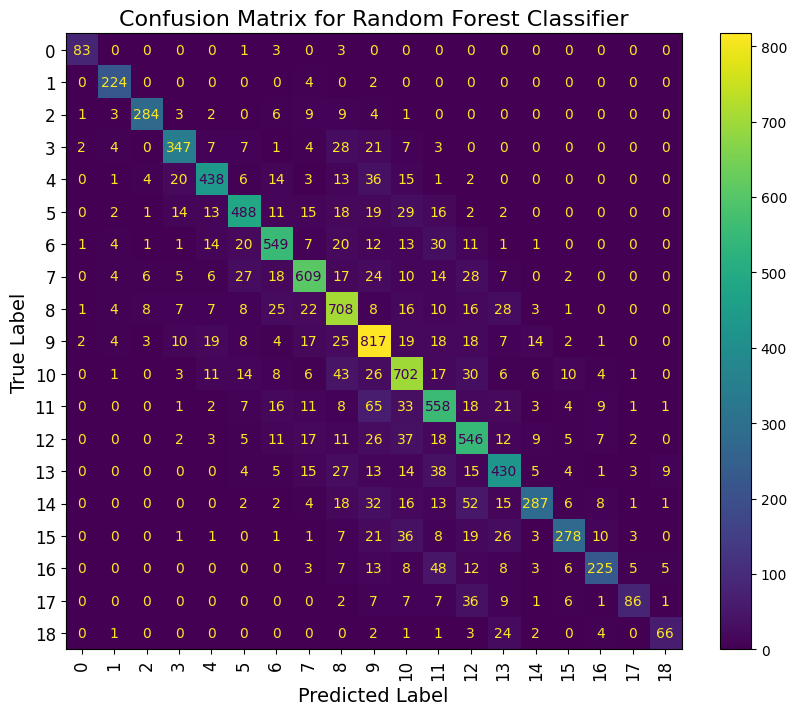

In [10]:
# Generate a confusion matrix
conf_matrix_rf = confusion_matrix(y_test_double, y_test_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=np.unique(y_test_double))

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap="viridis", xticks_rotation="vertical",
          ax=ax, colorbar=True)

plt.title("Confusion Matrix for Random Forest Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Decision Tree Model
### Optuna Study

In [11]:
# Define the optuna objective function for the Decision Tree model
def objective(trial):
    # Define the hyperparameter search space
    max_depth = trial.suggest_categorical('max_depth', [ 20, 40, 60, 80, None])  # Maximum tree depth
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8, step=3)  # Minimum samples to split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4, step=1)  # Minimum samples per leaf

    # Create the Decision Tree model
    model_dt = DecisionTreeClassifier( max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                      max_features='sqrt', random_state=42, criterion='gini')
    
    # Perform cross-validation
    cv_scores = cross_val_score(model_dt, x_train_double_optuna, y_train_double_optuna, cv=3, scoring='accuracy', n_jobs=-1)
    
    # Return the mean cross-validation score
    return cv_scores.mean()

# Create an Optuna study
study_dt = optuna.create_study(direction='maximize', study_name="DecisionTree_Hyperparameter_Optimisation")

# Optimize the study
study_dt.optimize(objective, n_trials=30)

[I 2024-12-11 02:51:15,722] A new study created in memory with name: DecisionTree_Hyperparameter_Optimisation
[I 2024-12-11 02:51:16,044] Trial 0 finished with value: 0.2005999340185968 and parameters: {'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.2005999340185968.
[I 2024-12-11 02:51:16,324] Trial 1 finished with value: 0.21870081429258703 and parameters: {'max_depth': 80, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.21870081429258703.
[I 2024-12-11 02:51:17,304] Trial 2 finished with value: 0.19930019396660725 and parameters: {'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.21870081429258703.
[I 2024-12-11 02:51:17,556] Trial 3 finished with value: 0.21369983429056763 and parameters: {'max_depth': 60, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.21870081429258703.
[I 2024-12-11 02:51:17,812] Trial 4 finished with value: 0.2

### DT - Optuna Top 4 Results

In [12]:
# Create a table showing the top 4 best trials performed by Optuna for Decision Tree
# Extract the top 4 best trials from the Optuna study
best_trials_dt = study_dt.trials_dataframe().nlargest(4, "value")

# Create a list of dictionaries to hold the trial results
best_results_dt = []
for index, row in best_trials_dt.iterrows():
    trial = study_dt.trials[int(row['number'])]
    result = {
        'Trial': trial.number,
        'Value': trial.value,
        **trial.params  # Unpack hyperparameters
    }
    best_results_dt.append(result)

# Convert to a DataFrame
best_results_dt_df = pd.DataFrame(best_results_dt)

# Convert to a displayable table
table_best_trials_dt = tabulate(best_results_dt_df, headers='keys', tablefmt='grid')
print(table_best_trials_dt)

+----+---------+----------+-------------+---------------------+--------------------+
|    |   Trial |    Value |   max_depth |   min_samples_split |   min_samples_leaf |
+====+=========+==========+=============+=====================+====================+
|  0 |       1 | 0.218701 |          80 |                   5 |                  3 |
+----+---------+----------+-------------+---------------------+--------------------+
|  1 |      19 | 0.218701 |          80 |                   5 |                  3 |
+----+---------+----------+-------------+---------------------+--------------------+
|  2 |      21 | 0.218701 |          80 |                   5 |                  3 |
+----+---------+----------+-------------+---------------------+--------------------+
|  3 |      22 | 0.218701 |          80 |                   5 |                  3 |
+----+---------+----------+-------------+---------------------+--------------------+


### Decision Tree best model trained on larger dataset

In [13]:
# Extract the best hyperparameters for DecisionTreeClassifier
best_params_dt = study_dt.best_trial.params

# Train the best DecisionTreeClassifier model on the larger data set (50,000 samples)
best_model_dt = DecisionTreeClassifier(max_depth=best_params_dt['max_depth'], min_samples_split=best_params_dt['min_samples_split'],
                                       min_samples_leaf=best_params_dt['min_samples_leaf'], max_features='sqrt',  random_state=42)

# Fit the best model on the training set
best_model_dt.fit(x_train_double, y_train_double)

# Predict and evaluate on the test set
y_test_pred_dt = best_model_dt.predict(x_test_double)

# Generate the classification report as a dictionary for converting to table
report_dt = classification_report(y_test_double, y_test_pred_dt, output_dict=True)

# Define overall accuracy
accuracy_dt = accuracy_score(y_test_double, y_test_pred_dt)

# Prepare data for tabulation
table_data_dt = []
for label, metrics in report_dt.items():
    if label.isdigit():
        table_data_dt.append([
            int(label),
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}",])

# Add overall accuracy at the end as a new row
table_data_dt.append(["Overall Accuracy", "-", "-", f"{accuracy_dt:.4f}"])

# Create tabulated report
headers_dt = ["Class", "Precision", "Recall", "F1-Score"]
table_dt_report = tabulate(table_data_dt, headers=headers_dt, tablefmt="grid")
print(table_dt_report)

# Save the best svm model
dump(best_model_dt, 'Results/best_dt_model.joblib')

+------------------+-------------+----------+------------+
| Class            | Precision   | Recall   |   F1-Score |
+==================+=============+==========+============+
| 0                | 0.4077      | 0.5889   |     0.4818 |
+------------------+-------------+----------+------------+
| 1                | 0.5846      | 0.6913   |     0.6335 |
+------------------+-------------+----------+------------+
| 2                | 0.4841      | 0.5186   |     0.5007 |
+------------------+-------------+----------+------------+
| 3                | 0.3699      | 0.4617   |     0.4107 |
+------------------+-------------+----------+------------+
| 4                | 0.3562      | 0.3942   |     0.3742 |
+------------------+-------------+----------+------------+
| 5                | 0.3582      | 0.3968   |     0.3765 |
+------------------+-------------+----------+------------+
| 6                | 0.3309      | 0.3927   |     0.3591 |
+------------------+-------------+----------+-----------

['Results/best_dt_model.joblib']

### Decision Tree Classifier

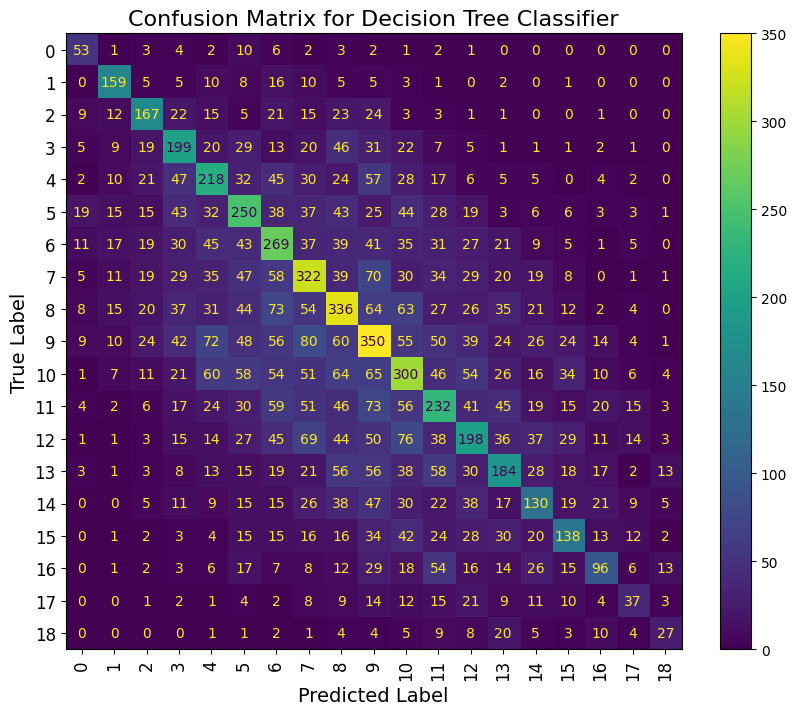

In [14]:
# Generate a confusion matrix
conf_matrix_dt = confusion_matrix(y_test_double, y_test_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, display_labels=np.unique(y_test_double))

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap="viridis", xticks_rotation="vertical",
          ax=ax, colorbar=True)

plt.title("Confusion Matrix for Decision Tree Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## AdaBoost Model
### Optuna Study

#### Hyperparameters Scanned Over
- **n_estimators**:  
  - The number of weak classifiers (base estimators) used in the ensemble.  
  - Range: 50 to 300 (in steps of 50).
- **learning_rate**:  
  - Controls the contribution of each weak classifier to the final ensemble.  
  - Range: 0.01 to 1.0 (logarithmic scale).

In [15]:
# Define the optuna objective function for the AdaBoost model
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)  # Number of weak classifiers
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)  # Learning rate

    # Create the AdaBoost model
    model_ab = AdaBoostClassifier(estimator =  DecisionTreeClassifier(max_depth=10), n_estimators=n_estimators, learning_rate=learning_rate, 
                                  algorithm='SAMME', random_state=42)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model_ab, x_train_double_optuna, y_train_double_optuna, cv=3, scoring='accuracy', n_jobs=-1)
    
    # Return the mean cross-validation score
    return cv_scores.mean()

# Create an Optuna study
study_ab = optuna.create_study(direction='maximize', study_name="AdaBoost_Hyperparameter_Optimisation")

# Optimize the study
study_ab.optimize(objective, n_trials=20)

[I 2024-12-11 02:51:24,927] A new study created in memory with name: AdaBoost_Hyperparameter_Optimisation
[I 2024-12-11 02:55:17,476] Trial 0 finished with value: 0.30850052611739875 and parameters: {'n_estimators': 150, 'learning_rate': 0.8662274251752182}. Best is trial 0 with value: 0.30850052611739875.
[I 2024-12-11 03:01:37,418] Trial 1 finished with value: 0.52789919063892 and parameters: {'n_estimators': 250, 'learning_rate': 0.04427611324133619}. Best is trial 1 with value: 0.52789919063892.
[I 2024-12-11 03:04:10,370] Trial 2 finished with value: 0.4804009195160668 and parameters: {'n_estimators': 100, 'learning_rate': 0.21451865705177642}. Best is trial 1 with value: 0.52789919063892.
[I 2024-12-11 03:09:15,110] Trial 3 finished with value: 0.5136001002619758 and parameters: {'n_estimators': 200, 'learning_rate': 0.1998225019674531}. Best is trial 1 with value: 0.52789919063892.
[I 2024-12-11 03:10:32,201] Trial 4 finished with value: 0.3481991570482783 and parameters: {'n_es

### Adaboost - Optuna Top 4 Results

In [16]:
# Create a table showing the top 4 best trials performed by Optuna for AdaBoost

# Extract the top 4 best trials from the Optuna study
best_trials_ab = study_ab.trials_dataframe().nlargest(4, "value")

# Create a list of dictionaries to hold the trial results
best_results_ab = []
for index, row in best_trials_ab.iterrows():
    trial = study_ab.trials[int(row['number'])]
    result = {
        'Trial': trial.number,
        'Value': trial.value,
        **trial.params  # Unpack hyperparameters
    }
    best_results_ab.append(result)

# Convert to a DataFrame
best_results_ab_df = pd.DataFrame(best_results_ab)

# Convert to a displayable table
table_best_trials_ab = tabulate(best_results_ab_df, headers='keys', tablefmt='grid')
print(table_best_trials_ab)

+----+---------+----------+----------------+-----------------+
|    |   Trial |    Value |   n_estimators |   learning_rate |
+====+=========+==========+================+=================+
|  0 |      17 | 0.5298   |            300 |       0.0255004 |
+----+---------+----------+----------------+-----------------+
|  1 |       8 | 0.528699 |            300 |       0.0956071 |
+----+---------+----------+----------------+-----------------+
|  2 |       1 | 0.527899 |            250 |       0.0442761 |
+----+---------+----------+----------------+-----------------+
|  3 |      13 | 0.5277   |            250 |       0.0660068 |
+----+---------+----------+----------------+-----------------+


### Adaboost Model best model trained on larger dataset

In [17]:
# Extract the best hyperparameters for AdaBoostClassifier
best_params_ab = study_ab.best_trial.params

# Train the best AdaBoostClassifier model on the larger data set (50,000 samples)
best_model_ab = AdaBoostClassifier(estimator =  DecisionTreeClassifier(max_depth=10), n_estimators=best_params_ab['n_estimators'], learning_rate=best_params_ab['learning_rate'],
                                   algorithm='SAMME', random_state=42)

# Fit the best model on the training set
best_model_ab.fit(x_train_double, y_train_double)

# Predict and evaluate on the test set
y_test_pred_ab = best_model_ab.predict(x_test_double)

# Generate the classification report as a dictionary for converting to table
report_ab = classification_report(y_test_double, y_test_pred_ab, output_dict=True)

# Define overall accuracy
accuracy_ab = accuracy_score(y_test_double, y_test_pred_ab)

# Prepare data for tabulation
table_data_ab = []
for label, metrics in report_ab.items():
    if label.isdigit():
        table_data_ab.append([
            int(label),
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}",
        ])

# Add overall accuracy at the end as a new row
table_data_ab.append(["Overall Accuracy", "-", "-", f"{accuracy_ab:.4f}"])

# Create tabulated report
headers_ab = ["Class", "Precision", "Recall", "F1-Score"]
table_ab_report = tabulate(table_data_ab, headers=headers_ab, tablefmt="grid")
print(table_ab_report)

# Save the best svm model
dump(best_model_ab, 'Results/best_ab_model.joblib')

+------------------+-------------+----------+------------+
| Class            | Precision   | Recall   |   F1-Score |
+==================+=============+==========+============+
| 0                | 0.9659      | 0.9444   |     0.9551 |
+------------------+-------------+----------+------------+
| 1                | 0.8926      | 0.9391   |     0.9153 |
+------------------+-------------+----------+------------+
| 2                | 0.9241      | 0.8323   |     0.8758 |
+------------------+-------------+----------+------------+
| 3                | 0.8517      | 0.7726   |     0.8102 |
+------------------+-------------+----------+------------+
| 4                | 0.8624      | 0.7251   |     0.7878 |
+------------------+-------------+----------+------------+
| 5                | 0.8004      | 0.7190   |     0.7575 |
+------------------+-------------+----------+------------+
| 6                | 0.7757      | 0.7372   |     0.756  |
+------------------+-------------+----------+-----------

['Results/best_ab_model.joblib']

### AdaBoost Confusion Matrix

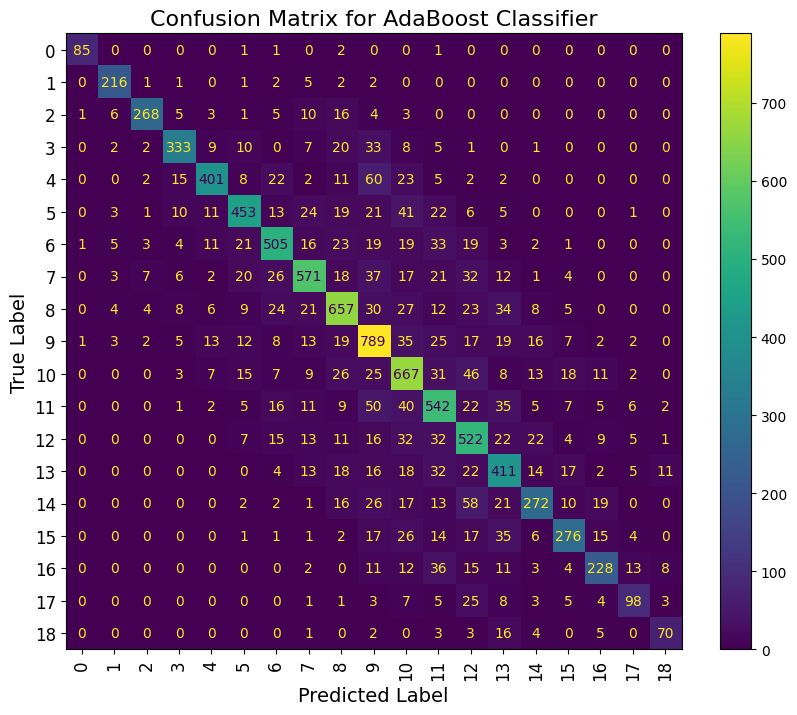

In [18]:
# Generate a confusion matrix
conf_matrix_ab = confusion_matrix(y_test_double, y_test_pred_ab)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ab, display_labels=np.unique(y_test_double))

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(cmap="viridis", xticks_rotation="vertical",
          ax=ax, colorbar=True)

plt.title("Confusion Matrix for AdaBoost Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

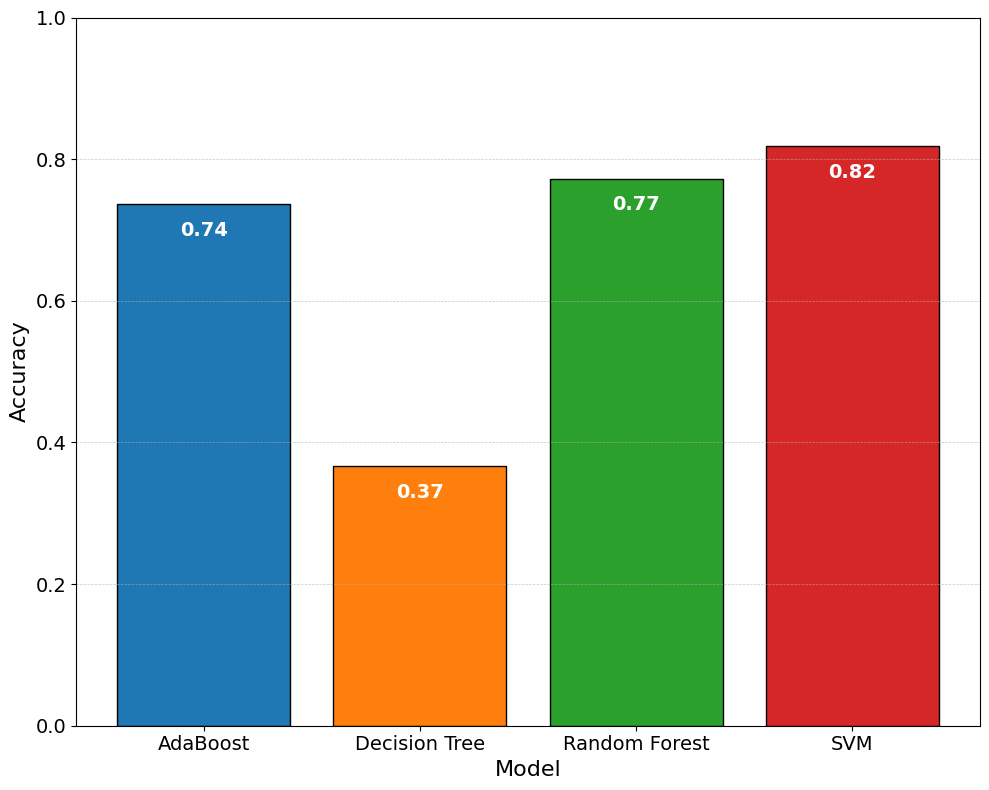

In [23]:
# Data for the bar chart
models = ['AdaBoost', 'Decision Tree', 'Random Forest', 'SVM']
accuracies = [accuracy_ab, accuracy_dt, accuracy_rf, accuracy_svm]

# Create the bar chart
plt.figure(figsize=(10, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  
bars = plt.bar(models, accuracies, color=colors, edgecolor='black')

plt.xlabel('Model', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0, 1) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{accuracy:.2f}', 
             ha='center', va='bottom', fontsize=14, color='white', fontweight='bold')

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()